# Computing displacements and strain rates

## Introduction
The ApRES radar system's primary purpose is to precisely measure the displacement of reflectors. These reflectors can be internal reflecting horizons within the ice or the interface between the ice and the bed or between the ice and the ocean. Displacement is measured in terms of distance from the radar and this is usually assumed to be in the vertical direction. Displacement is computed by comparing two ApRES measurements. Specifically, by comparing the complex-valued profiles that are produced from the raw ApRES measurements using a fourier transform. The comparison between profiles can be performed in a number of different ways. In xapres we use the coherence method, where the profiles are binned vertically and the complex coherence between the two binned profiles is computed. The phase of this coherence can be converted into vertical displacement {cite}`brennan_phase-sensitive_2014`.

xapres provides functions to compute displacements in this way, along with associated uncertainties. You can use just two profiles using `xapres.utils.compute_displacement`, which is suitable for attended surveys or when you want to compare just two time slices in an unattended survey, or compute a time series of displacement from multiple profiles using `displacement_timeseries`, which is suitable for unattended surveys.

## Computing displacements from two profiles
Let's load data from an 12-month unattended survey on Thwaites Glacier, West Antarctica. 

In [33]:
%load_ext autoreload

%autoreload 2
import sys
sys.path.append("../../../xapres") 
import xapres as xa

from_zarr = xa.load.load_zarr('gs://ldeo-glaciology/apres/thwaites/continuous/ApRES_LTG/zarr/full.zarr') 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Next we will extract two profiles seprated by around two days. 

In [34]:
p1 = from_zarr.sel(time='2023-07-17').isel(time=0)
p2 = from_zarr.sel(time='2023-07-19').isel(time=0)

Note that in the first line above `from_zarr.sel(time='2022-07-17')` selects al the data from the 17th of July 2022, then `.isel(time=0)` selects the first burst from that day. In the second line above the same thing is done for the 19th. 

Next we will average over all the chirps in each burst, which is usually referred to as stacking (see {ref}`page:how-to-stacking`). We then load the data into memory with `.load()`; it is lazily loaded by default (see {ref}`page:how-to-loading`).

In [35]:
p1_stacked = p1.profile.mean(dim='chirp_num').load()
p2_stacked = p2.profile.mean(dim='chirp_num').load()

To compute the displacement between the two profiles we use the function `xapres.utils.compute_displacement`:

In [36]:
profiles = xa.utils.compute_displacement(p1_stacked, p2_stacked)
profiles 

<xarray.Dataset> Size: 519kB
Dimensions:                     (attenuator_setting_pair: 1, shot_number: 2,
                                 profile_range: 11889, time: 1, bin_depth: 594)
Coordinates:
    AFGain                      (attenuator_setting_pair) int64 8B -4
    attenuator                  (attenuator_setting_pair) float64 8B 22.0
    burst_number                (shot_number) int64 16B 1 1
    filename                    (shot_number) <U90 720B 'gs://ldeo-glaciology...
    orientation                 <U7 28B 'unknown'
  * profile_range               (profile_range) float64 95kB 0.0 ... 2.5e+03
    profile_time                (shot_number, time) datetime64[ns] 16B 2023-0...
  * time                        (time) datetime64[ns] 8B 2023-07-18T16:08:49
  * shot_number                 (shot_number) int64 16B 1 2
  * bin_depth                   (bin_depth) float64 5kB 1.998 ... 2.496e+03
Dimensions without coordinates: attenuator_setting_pair
Data variables: (12/14)
    profile                     (shot_number, time, attenuator_setting_pair, profile_range) complex128 380kB ...
    coherence                   (time, attenuator_setting_pair, bin_depth) complex128 10kB ...
    phase                       (time, attenuator_setting_pair, bin_depth) float64 5kB ...
    phase_variance              (time, attenuator_setting_pair, bin_depth) float64 5kB ...
    displacement                (time, attenuator_setting_pair, bin_depth) float64 5kB ...
    disp_variance               (time, attenuator_setting_pair, bin_depth) float64 5kB ...
    ...                          ...
    strain_rate                 float64 8B 0.008068
    strain_rate_variance        float64 8B 7.549e-05
    surface_intercept           float64 8B -0.1421
    surface_intercept_variance  float64 8B 0.02775
    r_squared                   float64 8B 0.978
    sum_squared_residuals       float64 8B 256.8
Attributes:
    bin_size:     20
    description:  Time series of profiles of coherence, phase, displacement, ...
    processing:   Created by the compute_displacement function in xapres usin...

(0.0, 800.0)

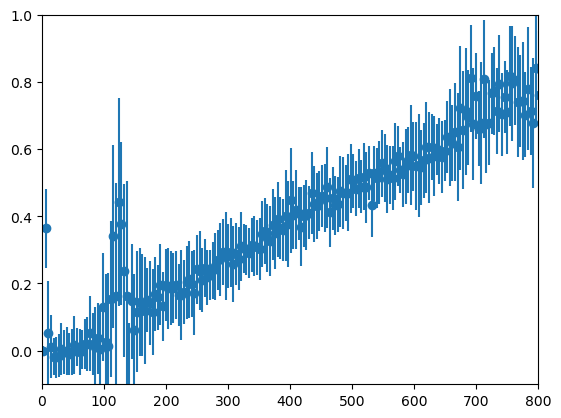

In [53]:
profiles = profiles.squeeze()
plt.errorbar(profiles['bin_depth'], profiles['phase'], yerr=profiles['phase_variance']**0.5, fmt='o')
plt.ylim(-0.1, 1)
plt.xlim(0, 800)

(0.0, 800.0)

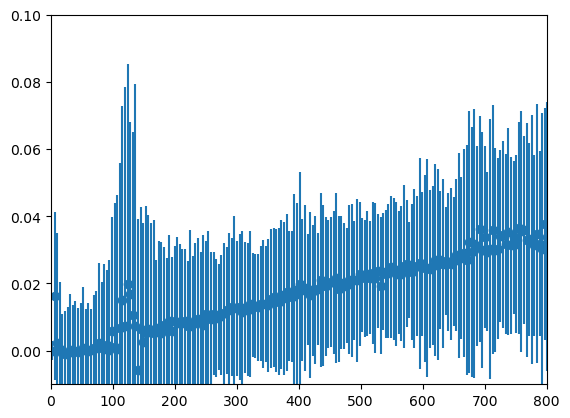

In [56]:
profiles = profiles.squeeze()
plt.errorbar(profiles['bin_depth'], profiles['displacement'], yerr=profiles['disp_variance']**0.5, fmt='o')
plt.ylim(-0.01, 0.1)
plt.xlim(0, 800)

(0.09, 1.0)

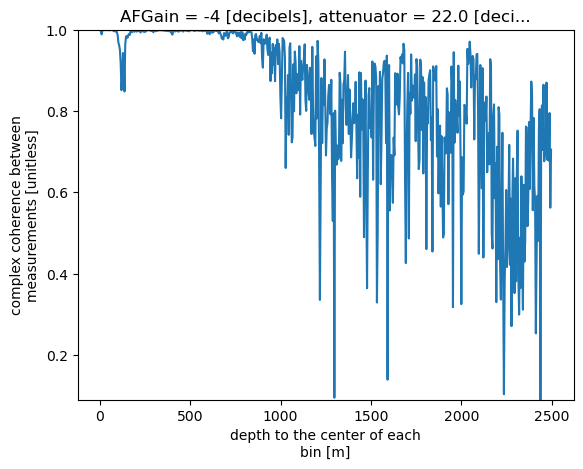

In [48]:
abs(profiles.coherence).plot()
plt.ylim(0.09, 1.0)

In [ ]:
((1/(abs(coherence)**2))*np.sqrt((1 - abs(coherence)**2)/(2*bin_size)))

This produces a new xarray dataset containing the original profiles and the following quantities computed in vertical bins
- the coherence between the profiles, 
- the phase difference, 
- the displacement 
- and the uncertainty in the displacement and phase difference.
  
From this you can plot the magnitude of the coherence, which is a measure of uncertainty in the displacement measurement. 

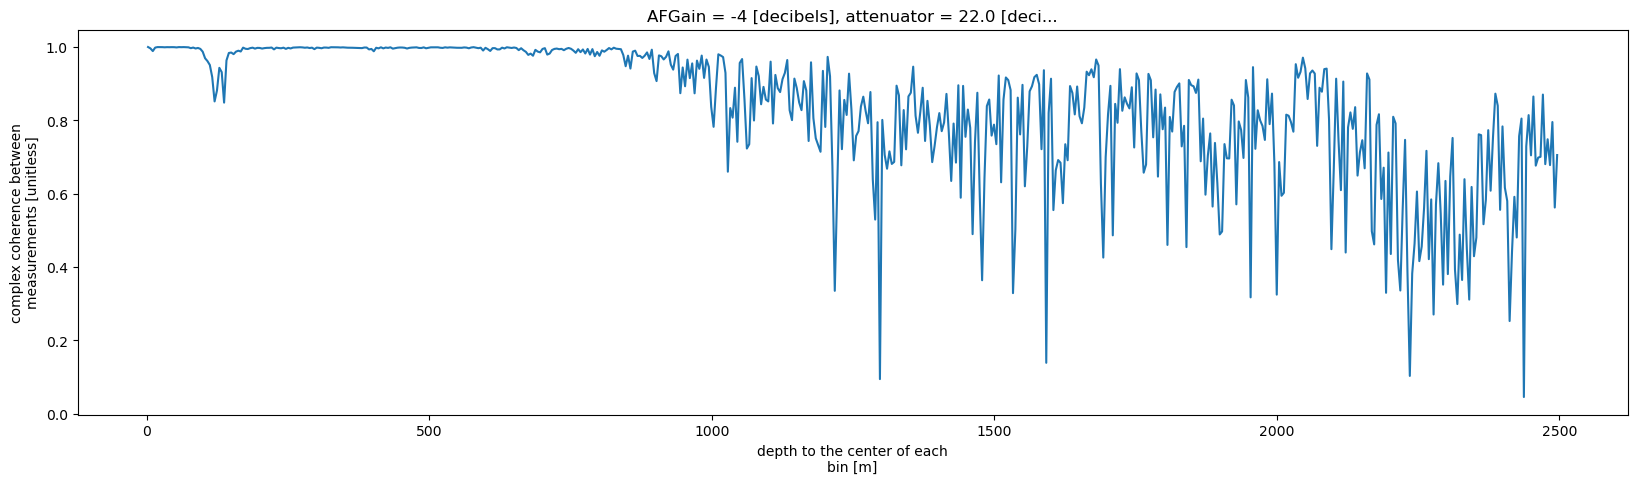

In [14]:
import numpy as np
np.abs(profiles.coherence).plot(figsize = (20,5), x = 'bin_depth');

You can also plot the phase difference,

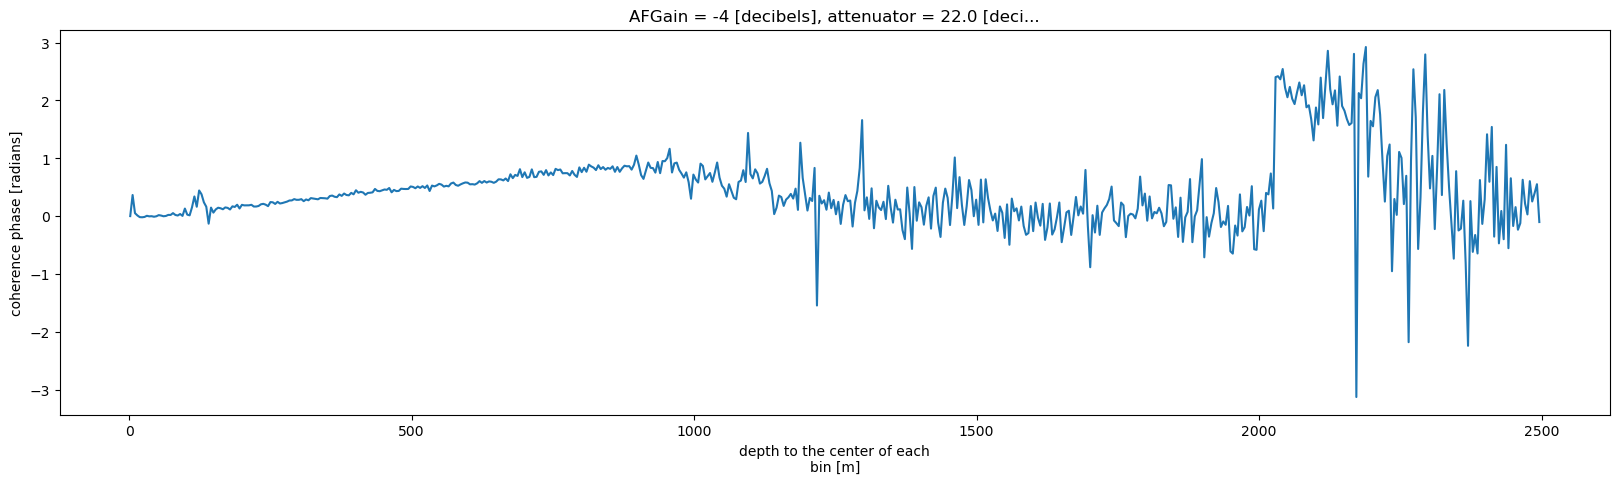

In [15]:
profiles.phase.plot(figsize = (20,5), x = 'bin_depth');

Finally, let's plot the vertical displacement while converting to centimeters, changing the axis limits, and adding error bars based on the variance in the displacment computed using the so-called *Cramer–Rao Bound* (eqn 67, [Rosen et al., 2000](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=838084)).

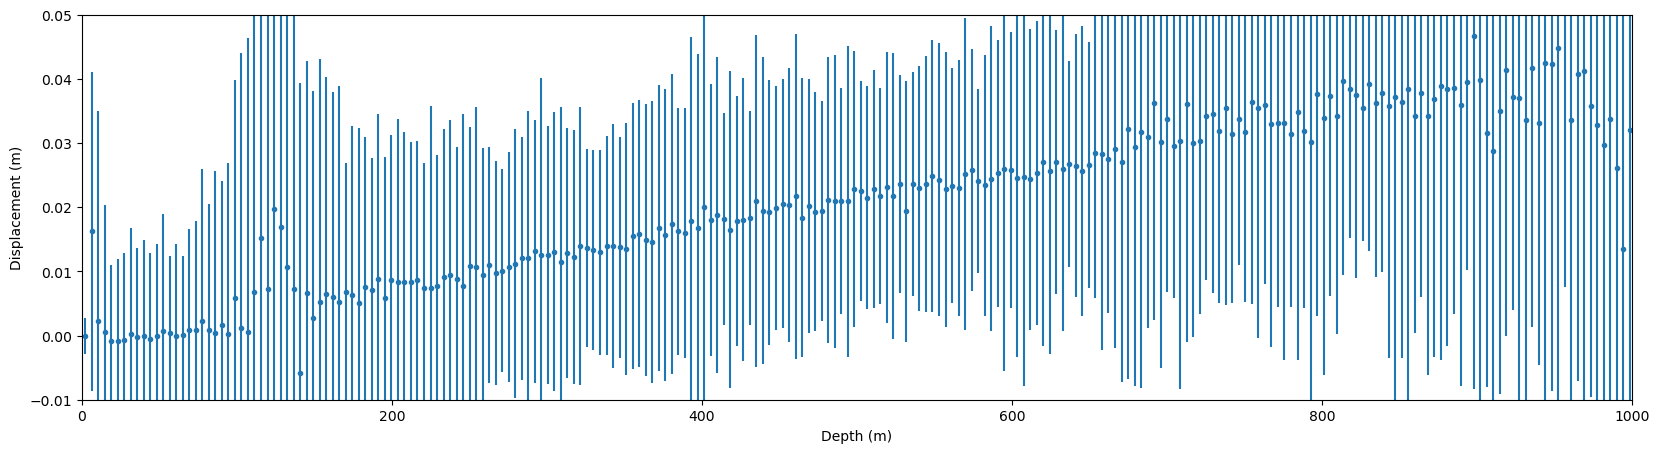

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (20,5))
x = profiles.bin_depth.values
y = profiles.displacement.values.squeeze()
yerr = (profiles.disp_variance.values.squeeze())**0.5
ax.errorbar(x=x, y=y, yerr=yerr, fmt='.')
ax.set_xlim(0, 1000)
ax.set_ylim(-0.01, 0.05)
ax.set_xlabel('Depth (m)')
ax.set_ylabel('Displacement (m)')
plt.show()

## Computing displacements from multiple profiles
You can also feed two datasets each containing multiple profiles into `compute_displacement` and it will compute the displacement between each pair of profiles. 

To demonstrate this we will create two time series of profiles from the full unattended survey on Thwaites Glacier stored in `from_zarr`. One of the two time series will consist of all the time slices except the last one and the other will consist of all the profiles except the first one. As shown in {numref}`fig:offset_in_time`, when you align these time series you get a time series of pairs of profiles that are separated by one time slice.


```{figure} images/offset_in_time.png
---
height: 200
name: fig:offset_in_time
---
Diagram showing the effect of combing two time series, one with the last time slice removed and the other with the first time slice removed.

```

In [ ]:
t1 = from_zarr.profile_stacked.isel(time=slice(0,-1))
t2 = from_zarr.profile_stacked.isel(time=slice(1,None))

We can feed both time series into `compute_displacement` and plot the results:

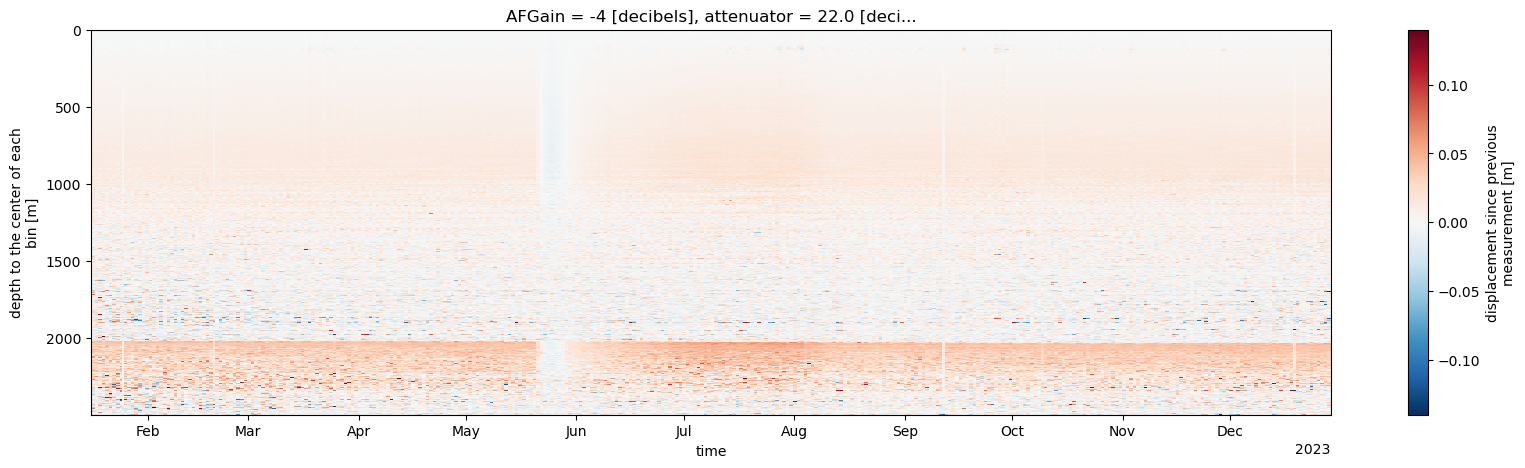

In [ ]:
xa.utils.compute_displacement(t1, t2)\
        .displacement\
        .plot(figsize = (20,5), y='bin_depth', x='time', yincrease = False);

### `displacement_timeseries`
This offset comparison between adjacent time slices is such a common procedure that xapres adds a method to xarray datasets called `displacement_timeseries` to do it for you. 

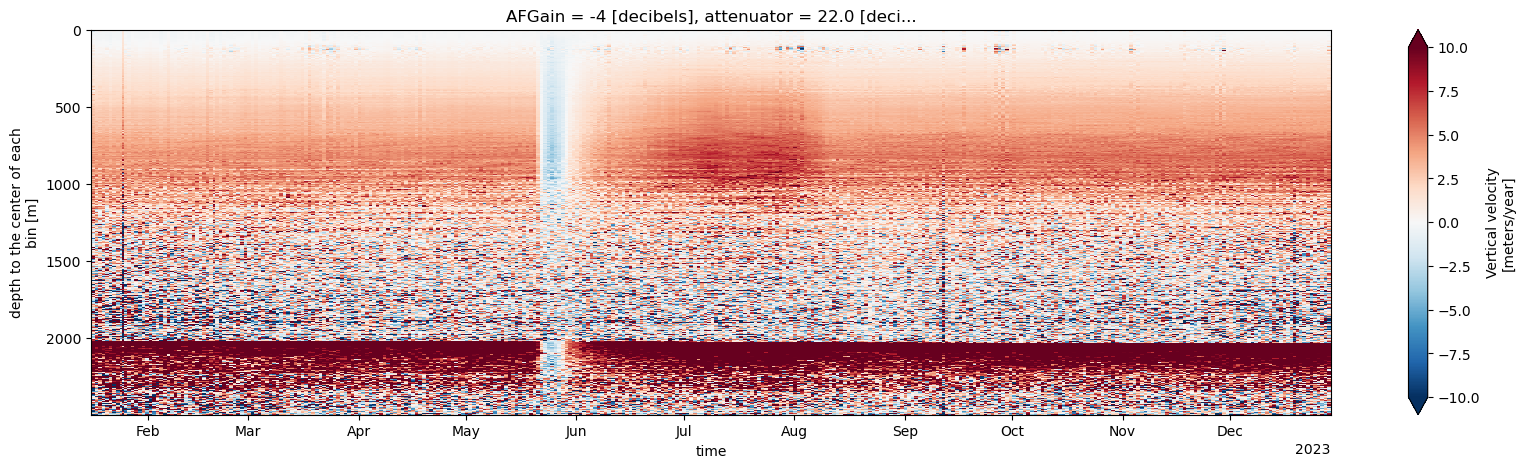

In [ ]:
from_zarr.profile_stacked.displacement_timeseries()\
        .velocity\
        .plot(figsize = (20,5), y='bin_depth', x='time', yincrease = False, vmin=-10, vmax=10, cmap ='RdBu_r');

### Options when computing displacements
You can set two optional parameters when computing vertical displacements with `displacement_timeseries`.

:offset: the number of time slices between the profiles to be compared. The default is 1. In other words, this is the number of time slices removed at the start and end of the time series before the two time series are aligned ({numref}`fig:offset_in_time`).
:bin_size: this is the vertical bin size in sample number. The default is 20. The samples are `profiles.profile_range[1]`=0.21 m apart. So the default of 20 samples produces bins around 4.2 m in height. 

```{note}
You can also set `offset` and `bin_size` when using `compute_displacement` directly. 
```

In general, increasing the bin size smooths vertically and increasing the offset smooths temporally, with associated losses in detail when things are changing rapidly in space or time. 
 

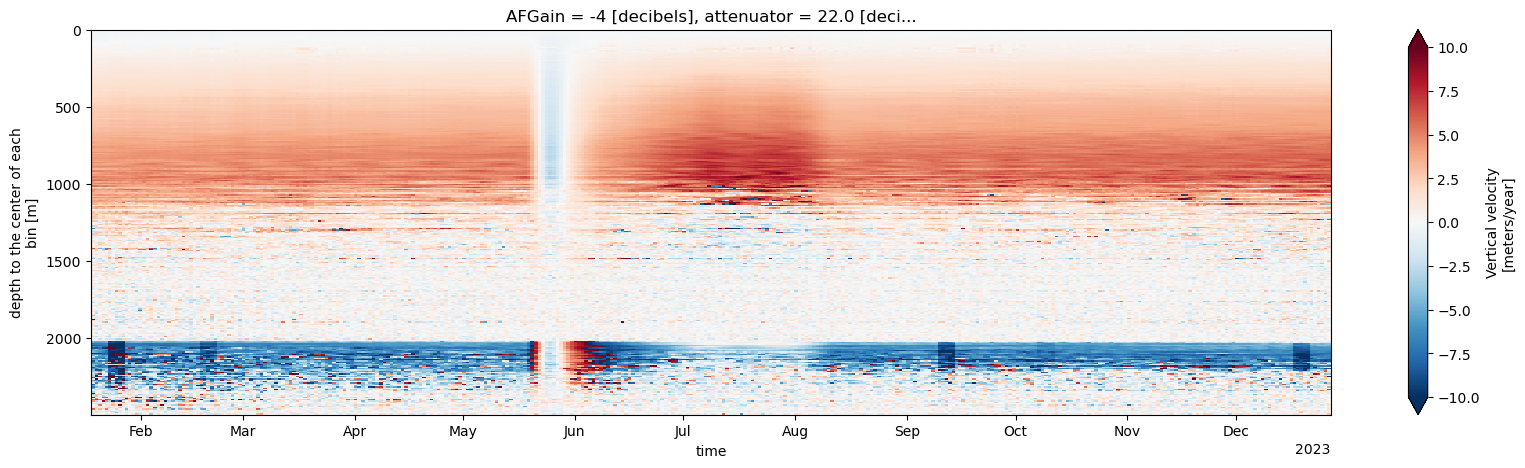

In [ ]:
from_zarr.profile_stacked.displacement_timeseries(bin_size = 40, offset = 5)\
        .velocity\
        .plot(figsize = (20,5), y='bin_depth', x='time', yincrease = False, vmin=-10, vmax=10, cmap ='RdBu_r');

## Strain rates
`displacement_timeseries` and `compute_displacement` also compute vertical strain rates in a simplified way using a linear fit to the vertical velocity profiles. The fit is a weighted least-squares fit perforedmed by numpy's polyfit. The weighting is inverse-variance weighting using the variance in the velocities estimated using the so-called *Cramer–Rao Bound* (eqn 67, [Rosen et al., 2000](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=838084)). By default, the linear fit this is performed using the upper 800 m of the ice column. 



In [32]:
from_zarr.load()

KeyboardInterrupt: 

In [30]:
from_zarr.profile_stacked.displacement_timeseries().strain_rate.plot(figsize = (20,5));

ValueError: dimension 'degree' in 'output_core_dims' needs corresponding (dim, size) in 'output_sizes'

The linear fit provides estimates of the variance of the strain rates. You can add error bars to the plot above based on these estimates as follows:

In [25]:
profiles.strain_rate.values.squeeze()

array(0.00806824)

In [27]:
plt.plot(from_zarr.profile_stacked.time.values, from_zarr.profile_stacked.displacement_timeseries().strain_rate.values.squeeze())

ValueError: apply_ufunc encountered a chunked array on an argument, but handling for chunked arrays has not been enabled. Either set the ``dask`` argument or load your data into memory first with ``.load()`` or ``.compute()``

You can also plot the r-squared value (the coefficient of determination) of the linear fits to the vertical velocity profiles.

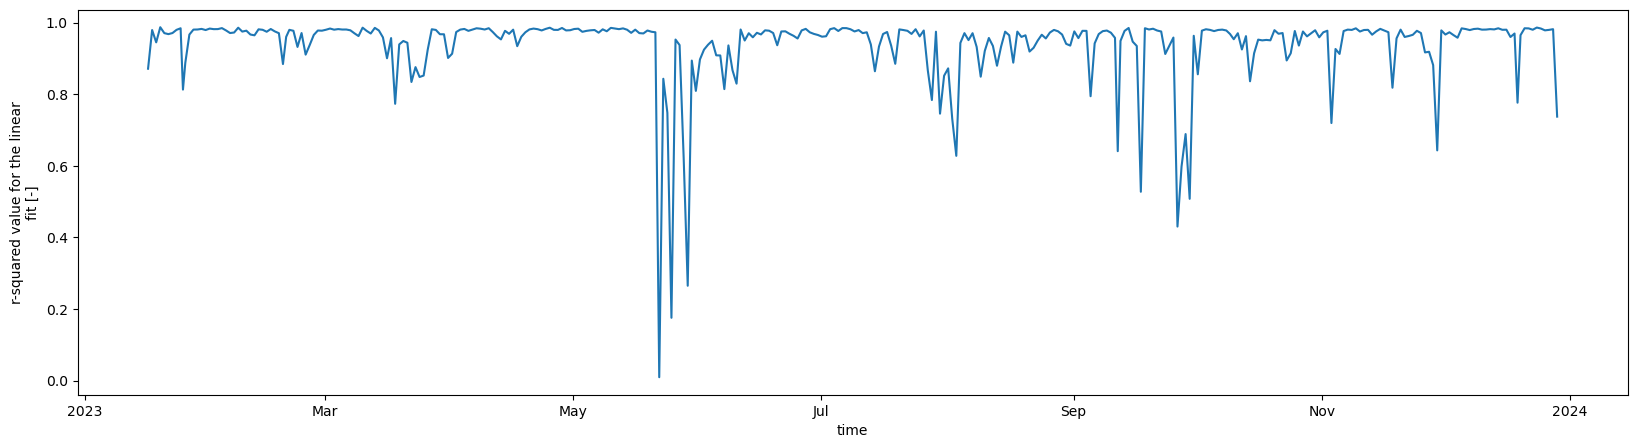

In [ ]:
from_zarr.profile_stacked.displacement_timeseries().r_squared.plot(figsize = (20,5));

To change the range of depths used in the fit, adjust optional parameters `min_depth_for_ezz_fit` and `max_depth_for_ezz_fit`:

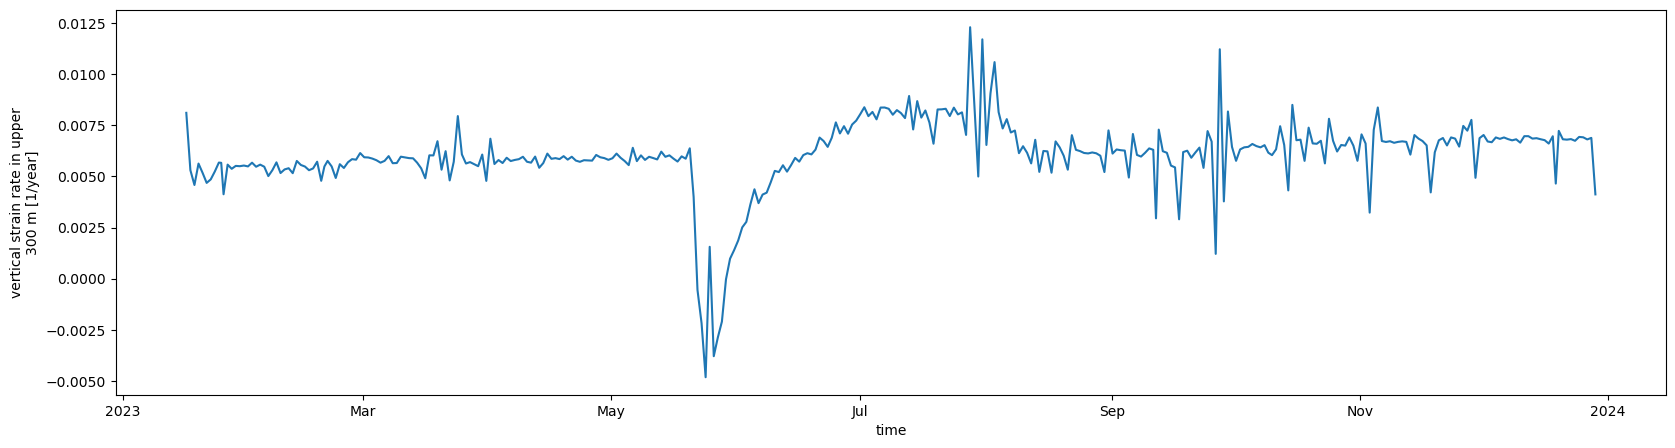

In [ ]:
from_zarr.profile_stacked.displacement_timeseries(min_depth_for_ezz_fit=50, max_depth_for_ezz_fit=500).strain_rate.plot(figsize = (20,5));

## Summary
You can compute displacements (and velocities, vertical strain rates, coherence, etc.) from pairs of ApRES profiles using `xapres.utils.compute_displacement` and `displacement_timeseries`.
Both functions take optional parameters to adjust the bin size and offset when computing displacements. 
They also compute vertical strain rates using a linear fit to the vertical velocity profiles in the upper part of the ice column. The depth range of velocity values used in this fit can be adjusted with `min_depth_for_ezz_fit` and `max_depth_for_ezz_fit`.